# DeepLabCut Speed Calculation

A Jupyter notebook to load DeepLabCut CSV output and calculate mouse speed based on tracked body parts.

## Setup Environment and Variables

Import necessary libraries (pandas, numpy). Define variables for the input directory (`input_dir`), DLC output filename (`file_name`), desired likelihood threshold (`likelihood_threshold`), and video frame rate (`frame_rate` in frames per second).

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from plotting_utils import plot_speed, create_synced_video_with_plot


# --- User Defined Variables ---

# Directory containing the DLC output CSV file
input_dir = r'C:\Users\Experiment\Projects\video_conversions'

# Name of the DLC CSV file (output from DLC analysis)
file_name = '2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000.csv' 

video_filename = file_name.split('DLC_resnet')[0] + '.mp4'
# Likelihood threshold - points below this threshold will be considered unreliable
likelihood_threshold = 0.98

# Frame rate of the video in frames per second (FPS)
frame_rate = 60

DEFAULT_BODYPARTS = [
    'neck', 'mid_back', 'mouse_center', 'mid_backend', 
    'mid_backend2', 'tail_base', 'left_midside', 
    'right_midside', 'left_hip', 'right_hip', 
    'left_shoulder', 'right_shoulder'
]
# Body parts to use for speed calculation.
# Provide a list of bodypart names, e.g., ['nose', 'mouse_center', 'tail_base'].
# If the list is empty or None, all bodyparts found in the file will be used.
bodyparts_for_calculation = [] # 'mouse_center', 'mid_back', 'neck'


# Construct the full file path
file_path = os.path.join(input_dir, file_name)

video_file_path = os.path.join(input_dir, video_filename)
if not os.path.exists(video_file_path):
    print(f"Warning: Video file not found at {video_file_path}. Video generation will be skipped.")
    create_synced_video = False
else:
    create_synced_video = True # Set to False to skip video generation
    print(f"Video file found: {video_file_path}")

print(f"Input Directory: {input_dir}")
print(f"File Name: {file_name}")
print(f"Full File Path: {file_path}")
print(f"Likelihood Threshold: {likelihood_threshold}")
print(f"Frame Rate (FPS): {frame_rate}")
print(f"Bodyparts for Speed Calculation: {'Default List' if not bodyparts_for_calculation else ('All' if bodyparts_for_calculation == ['all'] else bodyparts_for_calculation)}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Video file found: C:\Users\Experiment\Projects\video_conversions\2023-07-27_2_AV049_topCam_subset_start0_dur30.mp4
Input Directory: C:\Users\Experiment\Projects\video_conversions
File Name: 2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Full File Path: C:\Users\Experiment\Projects\video_conversions\2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Likelihood Threshold: 0.98
Frame Rate (FPS): 60
Bodyparts for Speed Calculation: ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend2', 'tail_base', 'left_midside', 'right_midside', 'left_hip', 'right_hip', 'left_shoulder', 'right_shoulder']


## Load DLC Data

Read the specified CSV file using pandas. Handle the multi-level header correctly (scorer, bodyparts, coords) by specifying the header rows. Display the first few rows and the structure (columns) of the loaded DataFrame.

In [26]:
# Check if the file exists before attempting to load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: The file was not found at the specified path: {file_path}")

# Load the CSV file, specifying the header rows
# DLC CSV files typically have a multi-level header:
# Row 0: Scorer
# Row 1: Bodyparts
# Row 2: Coordinates (x, y, likelihood)
try:
    df_dlc = pd.read_csv(file_path, header=[1, 2], index_col=0)
    print("DLC data loaded successfully.")
except Exception as e:
    print(f"Error loading CSV file: {e}")
    raise

# Display the first few rows
print("\nFirst 5 rows of the loaded data:")
print(df_dlc.head())

# Display the column structure (multi-index)
print("\nDataFrame Columns:")
print(df_dlc.columns)

# Display basic info
print("\nDataFrame Info:")
df_dlc.info()

DLC data loaded successfully.

First 5 rows of the loaded data:
bodyparts        nose                           left_ear              \
coords              x           y likelihood           x           y   
0          129.560760  402.219269   0.082019  125.590164  428.051331   
1          129.439468  402.191986   0.103668  125.987762  428.301971   
2          128.443726  402.066254   0.128062  125.967255  428.305847   
3          180.338257  461.936249   0.214642  126.092491  428.263580   
4          128.178284  402.274353   0.162708  126.445496  428.542267   

bodyparts              right_ear                        left_ear_tip  ...  \
coords    likelihood           x           y likelihood            x  ...   
0           0.999963  144.542648  416.686310   0.999965   125.109062  ...   
1           0.999970  145.142487  416.333038   0.999968   125.123558  ...   
2           0.999961  145.624374  416.984802   0.999956   124.321877  ...   
3           0.999942  146.140060  416.582764  

## Define Speed Calculation Strategy

Describe the chosen strategy for speed calculation.

**Chosen Strategy:**
1.  Identify the body parts to use for calculation based on the `bodyparts_for_calculation` list. If the list is empty, use all available body parts from the DLC file.
2.  For each selected body part, calculate the frame-to-frame displacement (Euclidean distance) *only if* the likelihood for that specific body part is above the `likelihood_threshold` in **both** the current frame and the preceding frame. If the likelihood criterion is not met for a body part in a given frame transition, its displacement for that transition is considered NaN.
3.  For each frame transition (from frame `t-1` to `t`), calculate the **average displacement** across all selected body parts that had a *valid* (non-NaN) displacement calculated in step 2.
4.  Convert this average displacement (pixels/frame) into speed (pixels/second) using the `frame_rate`.
5.  The speed for the very first frame will be NaN, as there is no preceding frame. Speed will also be NaN for transitions where *no* selected body parts met the likelihood criteria in both frames.

## Select and Filter Tracking Points

Select the x, y, and likelihood columns for the body part(s) chosen in the strategy. Apply the `likelihood_threshold`: set x, y coordinates to NaN for frames where the likelihood of the chosen point(s) is below the threshold.

In [ ]:
all_bodyparts = df_dlc.columns.get_level_values(0).unique().tolist()
print(f"\nAvailable bodyparts in file: {all_bodyparts}")

final_bodyparts_list = []
missing_parts = []
calculation_mode = None # To store how the list was derived ('all', 'default', 'custom')

if bodyparts_for_calculation == ['all']:
    final_bodyparts_list = all_bodyparts
    calculation_mode = 'all'
    print("\nUsing all available bodyparts for calculation.")
elif not bodyparts_for_calculation: # Empty list means use default
    requested_parts = DEFAULT_BODYPARTS
    calculation_mode = 'default'
    print(f"\nAttempting to use Default bodyparts list: {requested_parts}")
    # Validate default parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Default bodyparts were not found in the file and will be ignored: {missing_parts}")
else: # Custom list provided
    requested_parts = bodyparts_for_calculation
    calculation_mode = 'custom'
    print(f"\nAttempting to use Custom bodyparts list: {requested_parts}")
    # Validate custom parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Custom bodyparts were not found in the file and will be ignored: {missing_parts}")

# Final check and report
if not final_bodyparts_list:
    raise ValueError("Error: No valid bodyparts selected for calculation based on input and file contents.")

print(f"\nFinal list of bodyparts used for calculation ({calculation_mode} mode): {final_bodyparts_list}")


Using the following bodyparts for calculation: ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend2', 'tail_base', 'left_midside', 'right_midside', 'left_hip', 'right_hip', 'left_shoulder', 'right_shoulder']

Available bodyparts in file: ['nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint']


## Calculate Frame-by-Frame Displacement

Calculate the difference in x and y coordinates between consecutive frames for the filtered tracking point(s). Use the Euclidean distance formula: `sqrt(delta_x^2 + delta_y^2)` to find the displacement in pixels per frame. Handle potential NaN values introduced by filtering or inherent in the data.

In [28]:
# --- Calculate Displacement Per Bodypart with Likelihood Check ---

# Create a DataFrame to store the displacement for each selected bodypart
df_displacements = pd.DataFrame(index=df_dlc.index)

print("\nCalculating displacement for each selected bodypart...")

for bp in final_bodyparts_list:
    # Select x, y, and likelihood for the current bodypart
    x = df_dlc[(bp, 'x')]
    y = df_dlc[(bp, 'y')]
    likelihood = df_dlc[(bp, 'likelihood')]

    # --- Likelihood Check ---
    # Check if likelihood is above threshold in the current frame AND the previous frame
    # .shift(1) gets the value from the previous frame (row)
    likelihood_ok_current = likelihood >= likelihood_threshold
    likelihood_ok_previous = likelihood.shift(1) >= likelihood_threshold
    valid_transition_mask = likelihood_ok_current & likelihood_ok_previous

    # --- Calculate Displacement ---
    # Calculate difference between consecutive frames
    delta_x = x.diff()
    delta_y = y.diff()

    # Calculate Euclidean distance
    displacement = np.sqrt(delta_x**2 + delta_y**2)

    # --- Apply Mask ---
    # Keep displacement only if the transition is valid, otherwise set to NaN
    displacement_filtered = displacement.where(valid_transition_mask, np.nan)

    # Store the filtered displacement for this bodypart
    df_displacements[f'{bp}_displacement'] = displacement_filtered
    # print(f"  - Calculated displacement for {bp}. Valid transitions: {valid_transition_mask.sum()}") # Optional: uncomment for detailed logging

print("\nDisplacements calculated. First 5 rows of displacement data:")
print(df_displacements.head())

# Display how many NaNs per bodypart displacement column
print("\nNaN counts per bodypart displacement:")
print(df_displacements.isna().sum())


Calculating displacement for each selected bodypart...

Displacements calculated. First 5 rows of displacement data:
   neck_displacement  mid_back_displacement  mouse_center_displacement  \
0                NaN                    NaN                        NaN   
1           0.353071               0.458696                   0.154485   
2           0.676719               0.914901                   2.100668   
3           0.212862               0.672119                   1.233773   
4           1.121145               0.340454                   0.839752   

   mid_backend_displacement  mid_backend2_displacement  \
0                       NaN                        NaN   
1                  0.084794                   1.413764   
2                  4.146210                   4.257053   
3                  2.468946                   2.654865   
4                  2.399937                   3.663167   

   tail_base_displacement  left_midside_displacement  \
0                     NaN       

## Calculate Speed

Convert the displacement (pixels/frame) into speed (e.g., pixels/second). Use the `frame_rate` variable.

Speed = Displacement / Time per Frame
Time per Frame = 1 / `frame_rate`
Speed = Displacement / (1 / `frame_rate`) = Displacement * `frame_rate`

Store the calculated speed in a new column in the DataFrame. Handle the first frame (which has no preceding frame for displacement calculation) and frames where displacement is NaN.

In [29]:
create_plots = True # Set to False to skip plotting
plot_individual_parts = True # Set to False to plot only average speed
save_plots = True
smoothing_window_seconds = 1 # Smoothing window in s. Set to 0 for no smoothing.


Main DataFrame with Average Displacement and Speed columns added:
bodyparts                    analysis                         head_midpoint  \
coords    average_displacement_pixels speed_pixels_per_second    likelihood   
0                                 NaN                     NaN      0.999988   
1                            0.849588               50.975296      0.999989   
2                            2.082688              124.961258      0.999985   
3                            1.205676               72.340556      0.999978   
4                            1.851415              111.084902      0.999987   

bodyparts                           left_ear                          \
coords              x           y likelihood           x           y   
0          131.742157  416.166321   0.999963  125.590164  428.051331   
1          132.187180  416.067688   0.999970  125.987762  428.301971   
2          132.629913  416.369629   0.999961  125.967255  428.305847   
3          132.9573

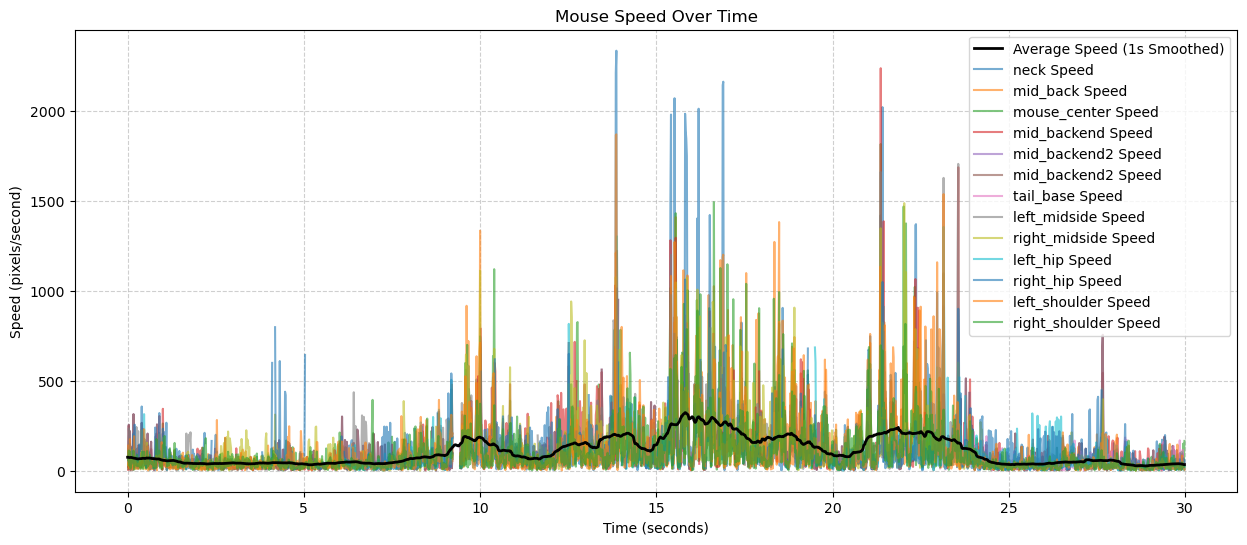

In [ ]:
# --- Calculate Average Displacement and Speed ---

# Calculate the mean displacement across all selected bodyparts for each frame
# .mean(axis=1) calculates the mean row-wise
# skipna=True is the default and crucial here - it ignores NaNs when averaging
# If all bodyparts have NaN displacement for a frame, the average will be NaN
average_displacement_pixels = df_displacements.mean(axis=1)

# Calculate the time elapsed per frame
time_per_frame = 1.0 / frame_rate # seconds per frame

# Calculate speed in pixels per second
# Speed = Average Displacement (pixels/frame) * Frame Rate (frames/second)
speed_pixels_per_second = average_displacement_pixels * frame_rate

# --- Add results to the main DataFrame ---
# Add the average displacement and final speed
df_dlc[('analysis', 'average_displacement_pixels')] = average_displacement_pixels
df_dlc[('analysis', 'speed_pixels_per_second')] = speed_pixels_per_second

# Sort columns for potentially better readability (optional)
df_dlc = df_dlc.sort_index(axis=1)

print("\nMain DataFrame with Average Displacement and Speed columns added:")
# Display head focusing on new columns if possible, or just head
print(df_dlc.head())
if ('analysis', 'average_displacement_pixels') in df_dlc.columns:
     print("\nShowing relevant columns from head:")
     print(df_dlc[[('analysis', 'average_displacement_pixels'), ('analysis', 'speed_pixels_per_second')]].head())


# Display summary statistics for the calculated speed
print("\nSpeed Summary Statistics (pixels/second):")
# Check if the speed column exists before describing
if ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print(df_dlc[('analysis', 'speed_pixels_per_second')].describe())
else:
    print("Speed column ('analysis', 'speed_pixels_per_second') not found.")


# --- Save the DataFrame with the speed column ---

# Define the subdirectory name
output_subdir = "speed_calculation"
# Create the full path for the output directory
output_dir_path = os.path.join(input_dir, output_subdir)

# Create the subdirectory if it doesn't exist
os.makedirs(output_dir_path, exist_ok=True)
print(f"\nEnsured output directory exists: {output_dir_path}")

base_name_without_ext = os.path.splitext(file_name)[0]
# Add '_all' suffix if the initial bodyparts_for_calculation list was empty
if calculation_mode == 'all':
    suffix = '_all_avg_speed'
elif calculation_mode == 'default':
    suffix = '_default_avg_speed'
elif calculation_mode == 'custom':
    if not final_bodyparts_list: # Should not happen due to check above, but safe
         print("Warning: Custom mode selected but final_bodyparts_list is empty.")
    elif len(final_bodyparts_list) == 1:
        parts_suffix = final_bodyparts_list[0]
        suffix = f'_{parts_suffix}_avg_speed'
    elif len(final_bodyparts_list) == 2:
        parts_suffix = '_'.join(final_bodyparts_list)
        suffix = f'_{parts_suffix}_avg_speed'
    else: # 3 or more parts
        parts_suffix = '_'.join(final_bodyparts_list[:2]) + '_etc'
        suffix = f'_{parts_suffix}_avg_speed'
else:
     print(f"Warning: Unknown calculation_mode '{calculation_mode}'. Using fallback suffix.")
# --- End suffix generation ---

base_output_name = base_name_without_ext + suffix
output_filename_csv = os.path.join(output_dir_path, base_output_name + '.csv')


# Save the DataFrame
try:
    df_dlc.to_csv(output_filename_csv)
    print(f"DataFrame with average speed saved to: {output_filename_csv}")
except Exception as e:
    print(f"Error saving CSV file: {e}")

if create_plots:
    if 'df_displacements' in locals() or 'df_displacements' in globals():
         plot_speed(df_dlc=df_dlc,
                    df_displacements=df_displacements,
                    final_bodyparts_list=final_bodyparts_list,
                    frame_rate=frame_rate,
                    output_dir=output_dir_path,
                    base_filename=base_output_name,
                    plot_individual=plot_individual_parts,
                    save_plot=save_plots,
                    smoothing_window_seconds=smoothing_window_seconds)
    else:
        print("Skipping plotting: Displacement data ('df_displacements') not found.")
else:
    print("\nPlotting is disabled (create_plots=False).")

In [31]:
# --- Cell for Creating Synchronized Video ---

# Only run if video file was found and create_synced_video is True
if create_synced_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation ---")

   

    # Define output video path
    video_output_filename = base_output_name + '_synced_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # --- Prepare Smoothed Speed Data ---
    # Calculate smoothing window in frames
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1:
            smoothing_window_frames = 1
        print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
        # Use rolling average on the speed column
        # center=False aligns the window to the right (causal smoothing)
        # min_periods=1 ensures output even at the beginning
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
    else:
        print("No smoothing applied to speed for video plot.")
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        smoothing_window_frames = 1 # For passing to function if needed

    # Call the video creation function
    create_synced_video_with_plot(
        video_path=video_file_path,
        speed_data=smoothed_speed, # Pass the smoothed data
        frame_rate=frame_rate,
        output_video_path=output_video_path,
        plot_width_seconds=5.0,  # Adjust how many seconds the plot shows
        plot_height_pixels=200, # Adjust plot height
    )
  
elif not create_synced_video:
    print("\nSkipping synchronized video generation because 'create_synced_video' is False or video file was not found.")
else:
    print("\nSkipping synchronized video generation: Prerequisite data ('df_dlc' or speed column) not available.")



--- Starting Synchronized Video Generation ---
Calculating smoothed speed with window: 60 frames (1s)
Starting synchronized video creation: C:\Users\Experiment\Projects\video_conversions\speed_calculation\2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000_neck_mid_back_mouse_center_mid_backend_mid_backend2_mid_backend2_tail_base_left_midside_right_midside_left_hip_right_hip_left_shoulder_right_shoulder_avg_speed_synced_video.mp4
Writing final video to C:\Users\Experiment\Projects\video_conversions\speed_calculation\2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000_neck_mid_back_mouse_center_mid_backend_mid_backend2_mid_backend2_tail_base_left_midside_right_midside_left_hip_right_hip_left_shoulder_right_shoulder_avg_speed_synced_video.mp4...
Moviepy - Building video C:\Users\Experiment\Projects\video_conversions\speed_calculation\2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampl

t:   0%|          | 0/1800 [00:00<?, ?it/s, now=None]

Error during video creation: [Errno 22] Invalid argument

MoviePy error: FFMPEG encountered the following error while writing file C:\Users\Experiment\Projects\video_conversions\speed_calculation\2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000_neck_mid_back_mouse_center_mid_backend_mid_backend2_mid_backend2_tail_base_left_midside_right_midside_left_hip_right_hip_left_shoulder_right_shoulder_avg_speed_synced_video.mp4:

 b'C:\\Users\\Experiment\\Projects\\video_conversions\\speed_calculation\\2023-07-27_2_AV049_topCam_subset_start0_dur30DLC_resnet50_downsampled_trialJul11shuffle1_150000_neck_mid_back_mouse_center_mid_backend_mid_backend2_mid_backend2_tail_base_left_midside_right_midside_left_hip_right_hip_left_shoulder_right_shoulder_avg_speed_synced_video.mp4: No such file or directory\r\n'
